In [1]:
!pip install pydot
import numpy as np
import tensorflow as tf
import pydot
from IPython.display import SVG
import scipy.misc
import matplotlib.pyplot as plt
from resnets_utils import *
print(tf.__version__)

2.4.0


In [2]:
def identity_block(x, f, filters, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    x_shortcut = x
    x = tf.keras.layers.Conv2D(filters=F1, kernel_size=(1,1), strides=(1,1),
                               padding='valid', name = conv_name_base+'2a',
                               kernel_initializer='glorot_uniform')(x)
    x = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base+'2a')(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1),
                               padding='same', name = conv_name_base+'2b',
                               kernel_initializer='glorot_uniform')(x)
    x = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base+'2b')(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1),
                               padding='valid', name = conv_name_base+'2c',
                               kernel_initializer='glorot_uniform')(x)
    x = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base+'2c')(x)
    
    x = tf.keras.layers.Add()([x, x_shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [3]:
tf.compat.v1.reset_default_graph()

with tf.compat.v1.Session() as test:
    np.random.seed(1)
    A_prev = tf.compat.v1.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = identity_block(A_prev, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')
    test.run(tf.compat.v1.global_variables_initializer())
    out = test.run([A], feed_dict={A_prev: X, tf.keras.backend.learning_phase(): 0})
    print("out = " + str(out[0][1][1][0]))

out = [0.8099722 0.        1.0938673 1.4293395 0.        1.5134495]


In [4]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    X_shortcut = X

    X = tf.keras.layers.Conv2D(F1, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = 'glorot_uniform')(X)
    X = tf.keras.layers.BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(F2,  kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = 'glorot_uniform')(X)
    X = tf.keras.layers.BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = 'glorot_uniform')(X)
    X = tf.keras.layers.BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    
    X_shortcut = tf.keras.layers.Conv2D(F3, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = 'glorot_uniform')(X_shortcut)
    X_shortcut = tf.keras.layers.BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X) 
    return X

In [5]:
tf.compat.v1.reset_default_graph()

with tf.compat.v1.Session() as test:
    np.random.seed(1)
    A_prev = tf.compat.v1.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = convolutional_block(A_prev, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')
    test.run(tf.compat.v1.global_variables_initializer())
    out = test.run([A], feed_dict={A_prev: X, tf.keras.backend.learning_phase(): 0})
    print("out = " + str(out[0][1][1][0]))

out = [0.7135476  0.5568191  0.         0.         0.         0.06087956]


In [6]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    X_input = tf.keras.layers.Input(input_shape)
    X = tf.keras.layers.ZeroPadding2D((3, 3))(X_input)
    
    X = tf.keras.layers.Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = 'glorot_uniform')(X)
    X = tf.keras.layers.BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = tf.keras.layers.AveragePooling2D((2, 2), name='avg_pool')(X)
    X = tf.keras.layers.Flatten()(X)
    X = tf.keras.layers.Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = 'glorot_uniform')(X)
    model = tf.keras.Model(inputs = X_input, outputs = X, name='ResNet50')
    return model

In [7]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

X_train = X_train_orig/255.
X_test = X_test_orig/255.

Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [10]:
model.fit(X_train, Y_train, epochs = 2, batch_size = 32)

Epoch 1/2
34/34 [==============================] - 105s 3s/step - loss: 2.4999 - accuracy: 0.3391
Epoch 2/2
34/34 [==============================] - 93s 3s/step - loss: 0.7241 - accuracy: 0.7627


In [11]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 3s 238ms/step - loss: 4.1657 - accuracy: 0.1667
Loss = 4.165719032287598
Test Accuracy = 0.1666666716337204


In [12]:
model = tf.keras.models.load_model('ResNet50.h5')

In [13]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 3s 244ms/step - loss: 0.5302 - accuracy: 0.8667
Loss = 0.5301783084869385
Test Accuracy = 0.8666666746139526


In [14]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

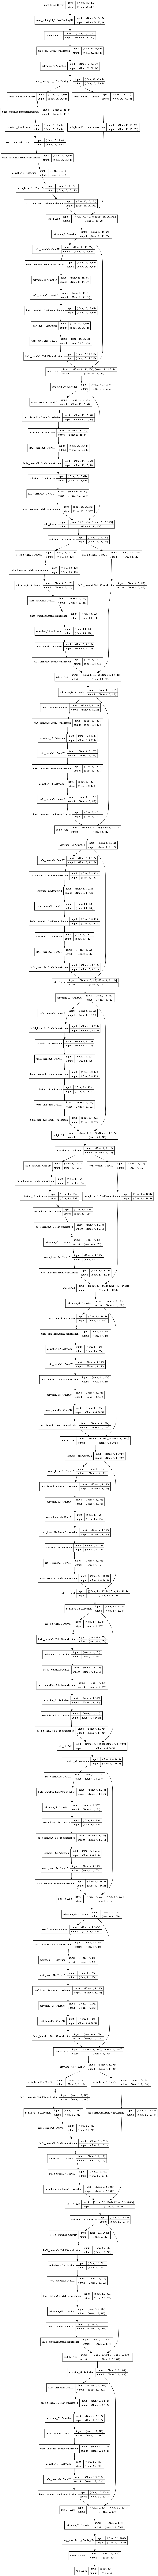

In [29]:
import pydot, pydotplus, graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'
tf.keras.utils.plot_model(model, to_file='resnets.png', show_shapes=True, show_dtype=False,
    show_layer_names=True)